In [1]:
import os
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial import distance
plt.rcParams['figure.dpi'] = 100
import matplotlib.backends.backend_pdf

In [7]:
# find current working directoy
cwd_path = Path().absolute()
data_root = cwd_path.parent.parent / "data"
experiment = "cerebellum"
chrom_list = [f"chr{x}" for x in range(1, 20)]
chrom_list.append("chrX")

# Specify the cells and markers you want to check

In [8]:
cell_types = ["Granule", "Purkinje", "MLI1",  "MLI2+PLI", "Bergmann"]
marker = "RNAPIISer5-P"
cols = [f"{marker}_{ct}" for ct in cell_types]

# Read the scRNA expression and celltype specific PolII expression profile (Already exclude chrX)

In [10]:
IF_sc_df = pd.read_csv( str(data_root /  experiment / "Fig3" / "long_gene_polII_scRNAcounts.csv"))
# take a look 
IF_sc_df

,gene,avrg_gene_density,Xist_RNA_Granule,ITS1_RNA_Granule,Rnu2_RNA_Granule,polyA_RNA_Granule,Malat1_RNA_Granule,CPSF6_Granule,ATRX_Granule,H4K8ac_Granule,...,Granule,Macrophage,Microglia,MLI1,MLI2,ODC,OPC,Purkinje,UBC,MLI2+PLI
0,1700025G04Rik,1.500000,-0.142920,-0.170490,0.137040,0.157050,0.047669,0.487510,0.411120,0.576840,...,3.233665,-0.565608,-0.557177,-0.634436,-0.692221,0.644668,1.205107,-0.659925,0.624360,-0.532921
1,1700123O12Rik,1.000000,-0.148760,-0.184870,-0.286940,-0.134170,-0.314690,-0.223930,0.038487,-0.092274,...,0.894271,-2.338208,-0.572934,0.816456,0.486546,0.798020,0.243936,1.341292,-0.169007,0.789487
2,2210408I21Rik,1.000000,-0.152550,-0.188220,-0.375430,-0.213580,-0.388520,-0.205060,0.054802,-0.147110,...,-0.522609,-0.133382,-0.493535,-0.217414,-0.283523,-0.073251,-0.199496,-0.804057,-0.162543,-0.176193
3,2810404M03Rik,1.000000,-0.147470,-0.185710,-0.416470,-0.151965,-0.462080,-0.358780,-0.077777,-0.341560,...,0.679176,-0.595169,-0.339815,0.315076,0.636948,-0.183069,0.055435,0.493911,0.449892,0.519197
4,4921515E04Rik,1.000000,-0.123240,-0.108220,-0.600620,-0.331550,-0.601850,-0.663020,-0.241310,-0.691050,...,-0.203678,-1.324814,-1.324814,-0.655119,-0.111083,1.695017,1.545665,-0.424403,-0.404120,-0.129584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,Zfp804a,1.500000,-0.164275,-0.195780,-0.465970,-0.285350,-0.471535,-0.471165,-0.167045,-0.425005,...,0.206690,-0.595780,-0.643359,1.109230,-0.470141,-0.633882,0.132969,0.174582,0.769638,0.421671
863,Zfp804b,1.250000,-0.146980,-0.197230,-0.496835,-0.314470,-0.535165,-0.569310,-0.137640,-0.603310,...,-0.265846,-0.295022,-0.309180,-0.271090,-0.204688,-0.282317,-0.245880,-0.255155,3.996565,-0.191922
864,Zfpm2,1.333333,-0.121355,-0.110915,-0.047338,0.136875,-0.088702,0.417845,0.326315,0.652825,...,0.689442,-0.723509,-0.716118,0.919981,2.995491,-0.653851,-0.109786,-0.566029,-0.636939,2.286878
865,Zmat4,1.000000,-0.177580,-0.173595,-0.068400,-0.048633,-0.108900,-0.051305,0.203270,-0.032376,...,-0.359929,-0.364251,-0.364848,-0.363101,-0.333960,-0.362598,-0.353178,-0.355593,-0.362340,1.338002


# Compute correlation of gene expression and polII level

In [12]:
sc_mtx = IF_sc_df[cell_types].values # include Granule cell
mtx = IF_sc_df[cols].values # include Granule cell

corr = []
for i in range(mtx.shape[0]):
    x = mtx[i]
    y = sc_mtx[i]
    corr.append(np.corrcoef(x, y)[0, 1])
corr = np.array(corr)

In [16]:
# choose genes have higher then 0.8 correlation
c_idx = corr > 0.8

# subsample only high correlated genes
plot_df = IF_sc_df.iloc[c_idx, :]
# extract matrix information again from selected genes
sc_mtx = plot_df[cell_types].values
mtx = plot_df[cols].values

print(f"Extracted {len(mtx)} long genes")

Extracted 132 long genes


In [17]:
# take a look of high correlated genes
hvg_genes = plot_df[['gene']]
hvg_genes

,gene
13,A330093E20Rik
22,Adam12
27,Adamts2
32,Adarb2
36,Adgrl3
...,...
841,Vwa8
848,Xkr4
851,Xylt1
859,Zfp423


In [26]:
# cluster genes by scRNA noramlized counts
# get the row idx from linkage 
row_linkage = linkage(distance.pdist(sc_mtx), method='ward')
idx = np.argsort(fcluster(row_linkage, t=3, criterion='distance'))
gene_order = list(plot_df.iloc[idx,:]['gene'])
selected_genes = ['Pam','Cntnap5a','Cntnap5b','Dpp10','Adgrl3','Slc4a4','Kcnd2','Cadps2',]
gene_order

['Lrrc7',
 'Sh3rf3',
 'Cntn4',
 'Pam',
 'Nxph1',
 'Cacna2d3',
 'Camta1',
 'Upp2',
 'Me3',
 'Zfpm2',
 'Epb41l3',
 'Nrxn3',
 'Ppm1l',
 'Fam155a',
 'Fam189a1',
 'Chchd3',
 'Spock3',
 'Kcnq1',
 'Sntg1',
 'Dscam',
 'Ntm',
 'Mdga2',
 'Inpp4b',
 'Myo16',
 'Hcn1',
 'Kirrel3',
 'Grik3',
 'Sema3e',
 'Zfp423',
 'Erc2',
 'Slc24a3',
 'Hecw1',
 'Rora',
 'Cacna1d',
 'Btbd11',
 'Asic2',
 'Xkr4',
 'Unc5c',
 'Adamts2',
 'Plxna4',
 'Sorcs3',
 'Grid1',
 'Galnt18',
 'Adarb2',
 'Plch1',
 'Adgrl3',
 'Nell1',
 'Cdh18',
 'Arhgap26',
 'Cntnap5b',
 'Kcnip1',
 'Dpp10',
 'Shank2',
 'Cacnb2',
 'Lrfn5',
 'Shisa6',
 'Thsd7a',
 'Dner',
 'Sox5',
 'Gm29536',
 'Rasal2',
 'Magi2',
 'Dgki',
 'Frmd4a',
 'Phactr2',
 'Vav3',
 'Vwa8',
 'Grm7',
 'Rbms1',
 'Ebf1',
 'Dach1',
 'Cdh12',
 'Cdk14',
 'Syt1',
 'Negr1',
 'Syne1',
 'Trhde',
 'Rims1',
 'Grik2',
 'Kcnd2',
 'Cadps2',
 'Gabrb2',
 'Fgf14',
 'Gabrb1',
 'Ank2',
 'Gria1',
 'Mcc',
 'Prex2',
 'Slc4a4',
 'Prkca',
 'Lsamp',
 'Shisa9',
 'Grin2b',
 'Trpm3',
 'Sox6',
 'Xylt1',
 'Sema6d

['Pam', 'Adgrl3', 'Cntnap5b', 'Dpp10', 'Kcnd2', 'Cadps2', 'Slc4a4']


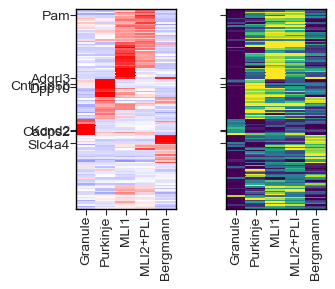

In [27]:
sns.set_style('ticks')

fig, axes = plt.subplots(figsize = (2.5, 2), ncols = 2, nrows = 1)

# get the row idx from linkage 
row_linkage = linkage(distance.pdist(sc_mtx), method='ward')
idx = np.argsort(fcluster(row_linkage, t=3, criterion='distance'))

# plot heatmap

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['b','w','r'])

fig1 = sns.heatmap(sc_mtx[idx, :], cmap = cmap, ax = axes[0], xticklabels = cell_types[0:], 
            vmin = -3, vmax = 3, yticklabels = [], cbar=False)
fig2 = sns.heatmap((mtx - mtx.min(axis = 1)[:,None])[idx, :], # subtract the min so that everyone starts from zero
            cmap = "viridis", ax = axes[1], xticklabels = cell_types[0:], vmin = 0, vmax = 1, yticklabels = [], 
            cbar=False)


yticks_pos = []
plot_genes = []
for i in range(len(gene_order)):
    if gene_order[i] in selected_genes:
        yticks_pos.append(i+0.5)
        plot_genes.append(gene_order[i])
print(plot_genes)
    
axes[0].set_yticks(yticks_pos)
axes[1].set_yticks(yticks_pos)
axes[0].set_yticklabels(plot_genes,size=10) # comment this part


for i in range(2):
    axes[i].get_xaxis().set_tick_params(direction='out',length=4)
    axes[i].get_yaxis().set_tick_params(direction='out',length=4)
    axes[i].tick_params(axis='both', which='major', labelsize=10, pad=0)
    
for axes[0] in ['top','bottom','left','right']:
    fig1.spines[axes[0]].set_visible(True)
    fig1.spines[axes[0]].set_color('black')
    fig1.spines[axes[0]].set_linewidth(1)
    
for axes[1] in ['top','bottom','left','right']:
    fig2.spines[axes[1]].set_visible(True)
    fig2.spines[axes[1]].set_color('black')
    fig2.spines[axes[1]].set_linewidth(1)
    
    
plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=1, 
                    wspace=0.5, 
                    hspace=0)

# Add intron information

In [28]:
int_mtx = pd.read_csv( str(data_root /  experiment / "Fig3" / 'high_correlated_long_gene_polII_intron.csv'))

['Pam', 'Adgrl3', 'Cntnap5b', 'Dpp10', 'Kcnd2', 'Cadps2', 'Slc4a4']


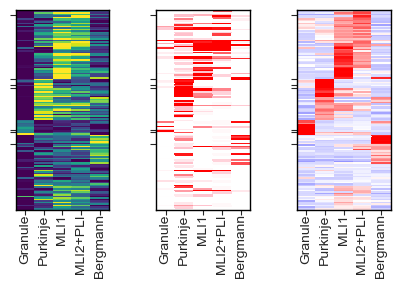

In [30]:
sns.set_style('ticks')

fig, axes = plt.subplots(figsize = (2.5*3/2, 2), ncols = 3, nrows = 1)

# get the row idx from linkage 
row_linkage = linkage(distance.pdist(sc_mtx), method='ward')
idx = np.argsort(fcluster(row_linkage, t=3, criterion='distance'))

# plot heatmap


cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['b','w','r'])
fig1 = sns.heatmap(sc_mtx[idx, :], cmap = cmap, ax = axes[2], xticklabels = cell_types[0:], 
            vmin = -3, vmax = 3, yticklabels = [], cbar=False)

fig2 = sns.heatmap((mtx - mtx.min(axis = 1)[:,None])[idx, :], # subtract the min so that everyone starts from zero
            cmap = "viridis", ax = axes[0], xticklabels = cell_types[0:], vmin = 0, vmax = 1.2, yticklabels = [], 
            cbar=False)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['w','pink','r'])
fig3 = sns.heatmap(np.log10(int_mtx), cmap = cmap, ax = axes[1], xticklabels = cell_types[0:], 
            vmin = -2, vmax = -1, yticklabels = [], cbar=False)

yticks_pos = []
plot_genes = []
for i in range(len(gene_order)):
    if gene_order[i] in selected_genes:
        yticks_pos.append(i+0.5)
        plot_genes.append(gene_order[i])
print(plot_genes)
    
axes[0].set_yticks(yticks_pos)
axes[1].set_yticks(yticks_pos)
axes[2].set_yticks(yticks_pos)
#axes[0].set_yticklabels(plot_genes,size=10) # comment this part

for i in range(3):
    # axes[i].get_xaxis().set_tick_params(direction='out',length=4)
    axes[i].get_yaxis().set_tick_params(direction='out',length=4)
    axes[i].tick_params(axis='both', which='major', labelsize=10, pad=-0.5)
    
for axes[2] in ['top','bottom','left','right']:
    fig1.spines[axes[2]].set_visible(True)
    fig1.spines[axes[2]].set_color('black')
    fig1.spines[axes[2]].set_linewidth(1)
    
for axes[0] in ['top','bottom','left','right']:
    fig2.spines[axes[0]].set_visible(True)
    fig2.spines[axes[0]].set_color('black')
    fig2.spines[axes[0]].set_linewidth(1)
    
for axes[1] in ['top','bottom','left','right']:
    fig3.spines[axes[1]].set_visible(True)
    fig3.spines[axes[1]].set_color('black')
    fig3.spines[axes[1]].set_linewidth(1)
    
plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=1, 
                    wspace=0.5, 
                    hspace=0)

In [31]:
final_df = pd.DataFrame({"gene" : gene_order})
final_df[[f"mean_centered_RNAPIISer5-P_{ct}" for ct in cell_types]] = (mtx - mtx.min(axis = 1)[:,None])[idx, :]
final_df[[f"normalized_scRNA_count_{ct}" for ct in cell_types]] = sc_mtx[idx, :]
final_df[[f"log10_intron_counts_{ct}" for ct in cell_types]] = np.log10(int_mtx)
final_df[[f"intron_counts_{ct}" for ct in cell_types]] = int_mtx
final_df.to_csv(str(data_root /  experiment / "Fig3" / "FIg3g_resource.csv"), index = False)

/Users/yujing/miniconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
